# Лабораторная работа № 4. Статистический анализ данных о тепловой нагрузке блоков усиления мощности.

В работе проводится анализ данных о температуре и техническом состоянии совокупности блоков усиления мощности. Определяется взаимосвязь их технического состоянии с общим состоянием системы.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу. Под системой в этой работе мы будем понимать несколько БУМ, объединенных в единое целое. Тогда техническое состояние всей системы будет определяться техническим состоянием ее компонент, т.е. состоянием БУМ в данной работе. Техническое же состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача - спрогнозировать увеличение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков, который задает интенсивность нагрева, и возможный выход из строя всей системы блоков. Соответственно, необходимо определить критерий, на основании которого делается вывод о техническом состоянии системы, т.е. установить соответствие между состояниями блоков и состоянием системы. Именно этой задаче и будет посвящена данная лабораторная работа.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [5]:
df = pd.read_csv("./data/Lab4_data.csv")
df.head()

,mode,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,system_state
0,3,28.286114,28.043155,27.282141,28.704673,26.530050,30.627461,29.912560,29.724531,29.358333,1.0
1,4,34.142434,35.346311,34.829661,35.079161,35.740529,38.070576,38.675433,36.362013,35.819681,1.0
2,2,34.813586,36.781106,34.445407,34.423135,35.091298,37.398229,38.883147,36.309084,35.741195,1.0
3,4,39.946499,43.133120,40.372435,39.102817,42.374502,41.829684,44.227679,42.699515,41.328171,1.0
4,4,43.950857,47.014358,44.162152,43.810740,45.837267,45.189761,47.661803,46.020946,46.441315,1.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   mode          1205950 non-null  int64  
 1   temp1         1205950 non-null  float64
 2   temp2         1205950 non-null  float64
 3   temp3         1205950 non-null  float64
 4   temp4         1205950 non-null  float64
 5   temp5         1205950 non-null  float64
 6   temp6         1205950 non-null  float64
 7   temp7         1205950 non-null  float64
 8   temp8         1205950 non-null  float64
 9   temp9         1205950 non-null  float64
 10  system_state  1205950 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 101.2 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Следующие 9 колонок содержат в себе информацию о температуре каждого из 9-ти БУМ в каждый момент времени. Последняя колонка - бинарный признак работоспособности всей системы блоков.

## Определение температурных порогов отключения и включения блоков

Посмотрим на динамику температуры для каждого блока. Отчетливо видно, что существуют области почти линейного уменьшения температуры - периоды охлаждения блоков. В этом задании требуется определить температурные пороги, достижение которых приводит к отлючению блоков или, наоборот, к возврату их в работоспособное состояние. Также требуется сделать вывод о похожести блоков.

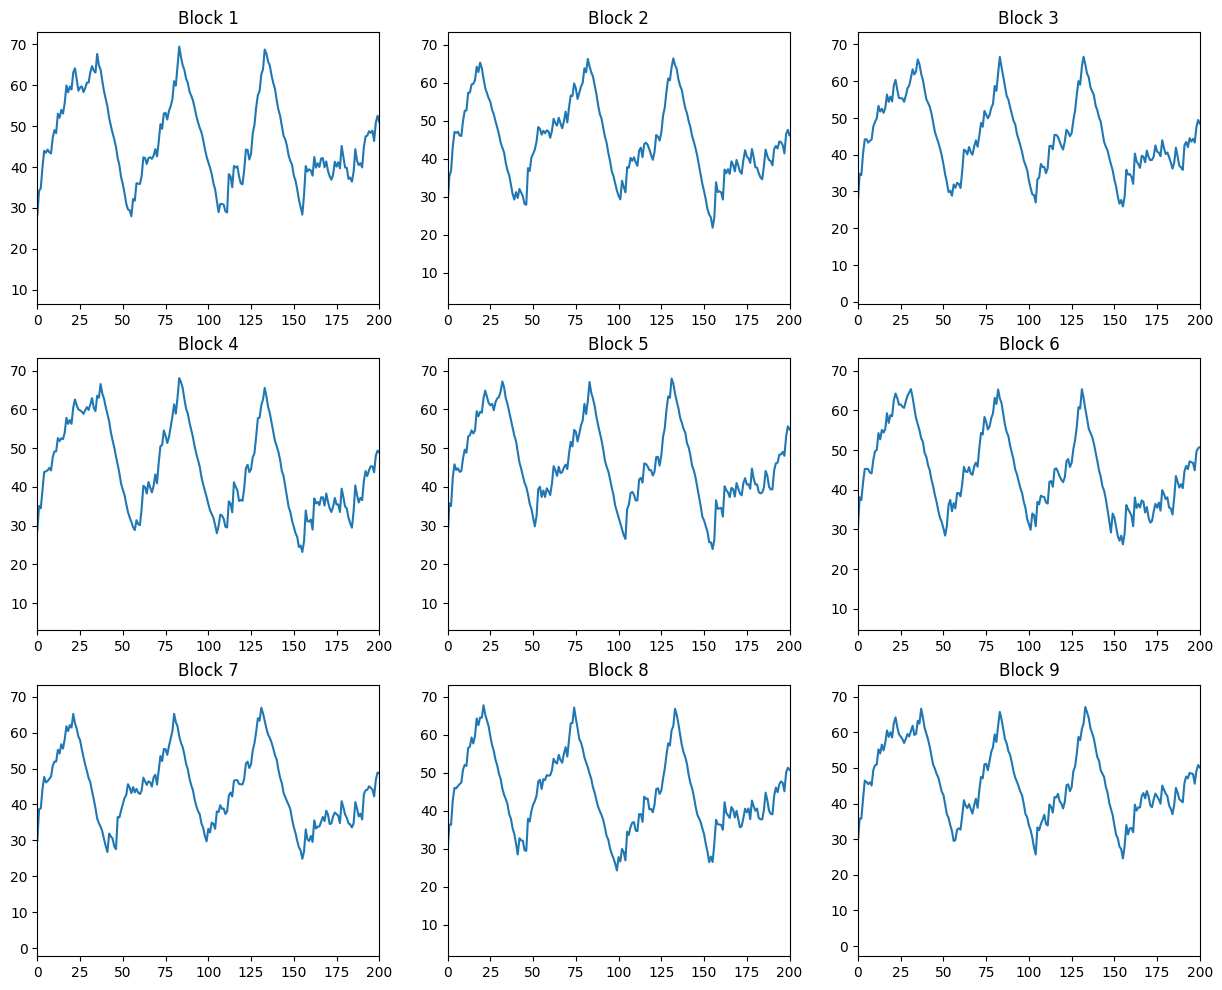

In [11]:
plt.figure(figsize=(15,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(df['temp'+str(i+1)])
    plt.xlim(0,200)
    plt.title('Block '+str(i+1))
plt.show()

#### **Задание 1**

Напишите функцию, которая бы по данным о температуре для конкретного блока (тип **Series**) определяла области, в которых происходит охлаждение блока. Параметр **threshold** задает минимальную длительность такой области.

In [12]:
def find_sequences(arr, threshold):
    sequences = []
    current_sequence = [arr[0]]

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_sequence.append(arr[i])
        else:
            if len(current_sequence) >= threshold:
                sequences.append(current_sequence)
            current_sequence = [arr[i]]

    # Проверяем последнюю последовательность
    if len(current_sequence) >= threshold:
        sequences.append(current_sequence)

    return sequences

def find_decreasing_regions(series, threshold = 10):

    decreasing_row = series.diff() < 0
    ans = find_sequences(series[decreasing_row].index.to_numpy(), threshold)

    return ans

find_decreasing_regions(df['temp1'])

[[36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55],
 [84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106],
 [134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155],
 [288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306],
 [366,
  367,
  368,
  369,
  370,
  371,
  372,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383],
 [406,
  407,
  408,
  409,
  410,
  411,
  412,
  413,
  414,
  415,
  416,
  417,
  418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427],
 [472,
  473,
  474,
  475,
  476,
  477,
  478,
  479,
  480,
  481,
  482,
  483,
  484,
  485,
  486,
  487,
  488,
  489,
  490,
  491],
 [527,
  528,
  529,


Определим области охлаждения для каждого блока

In [13]:
block_names = ['temp1','temp2','temp3','temp4','temp5','temp6','temp7','temp8','temp9']
decreasing_regions = [find_decreasing_regions(df[name]) for name in block_names]

#### **Задание 2**

Напишите функции, которые бы выдавали список значений температур, при которых произошло отключение блока и его повторное включение после охлаждения, для каждого блока.

In [14]:
def find_max_temp(regions, series):
    ans = []
    for region in regions:
      ans.append(series[region[0]-1])

    return ans

def find_min_temp(regions, series):
    ans = []
    for region in regions:
      ans.append(series[region[-1]])

    return ans

Определим значения температур, при которых произошло отключение блоков и их повторное включение после охлаждения.

In [15]:
max_temp = [find_max_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]
min_temp = [find_min_temp(decreasing_regions[i], df['temp'+str(i+1)]) for i in range(9)]

print(max_temp[0])
print(min_temp[0])

[67.65362001012114, 69.47289397840382, 68.73506863930571, 65.2157984388604, 65.67134686182747, 67.238047288516, 66.56147237362521, 65.1704250790735, 65.31073962323285, 66.9014485736048, 68.94594536271893, 65.26633452885424, 65.5561696403183, 65.16437235291335, 69.088888082454, 68.26830501636866, 65.16665357375895, 66.08009771439015, 66.94572543628584, 65.25723459124518, 67.74761717901077, 67.62430017525328, 68.439603799419, 67.82286860845628, 66.56442900445522, 65.22461644870435, 65.60167388424753, 66.01141668109965, 65.89008384120335, 67.57872236123235, 65.22816856952706, 68.47365165694697, 67.51554827206832, 65.44963864306371, 65.72685396485781, 65.22838528342416, 65.03583176234136, 67.25605147917722, 65.66722454316785, 65.67301526642261, 65.20274494245348, 67.14945377061197, 65.8920852231849, 66.74749965160272, 66.91535423452862, 67.10124919333441, 65.41575562738271, 65.487122942331, 65.20531625384996, 67.73118164256678, 67.86259480271623, 65.76613270561263, 68.02164288384806, 65.36

Примените функцию ниже к полученным значениям температур. Наглядно сравните распределение верхних и нижних порогов температур для каждого блока. На основании этих распределений сделайте вывод о похожести блоков.

In [16]:
def hist_min_max_temp(min_max_temp, size=(15,12)):
    plt.figure(figsize=size)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.hist(min_max_temp[i], bins=100)
        plt.title('Block '+str(i+1))
    plt.show()

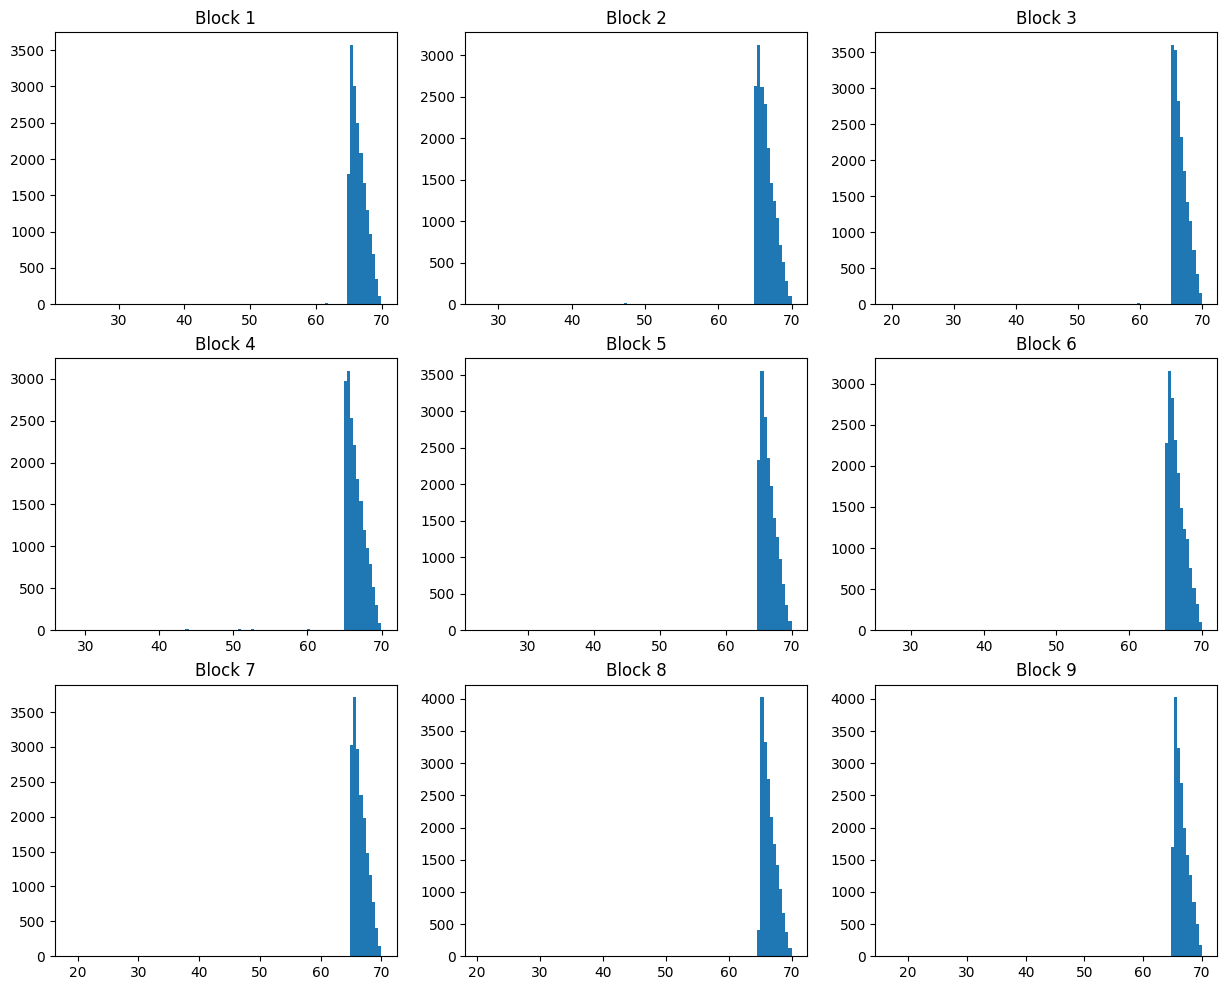

In [17]:
hist_min_max_temp(max_temp)

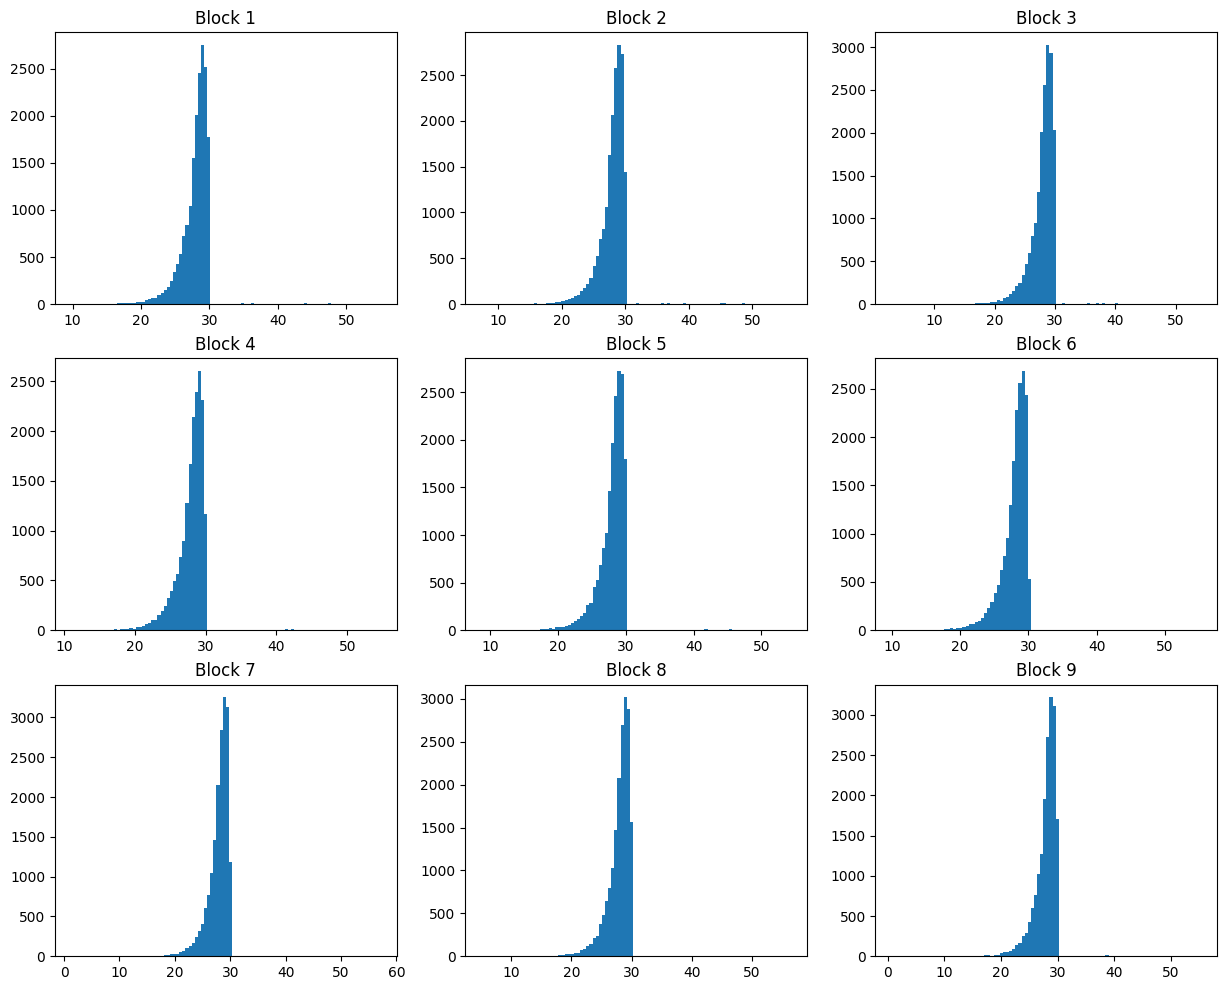

In [18]:
hist_min_max_temp(min_temp)

Вывод: напишите свой вывод здесь.

#### **Задание 3**

Определите средние значения температурных порогов для каждого блока и всех блоков в целом.

In [19]:
mean_max_temp = [np.mean(max_temp[i]) for i in range(9)] # напишите свой код здесь
mean_min_temp = [np.mean(min_temp[i]) for i in range(9)] # напишите свой код здесь

print('Mean max_temp: ', mean_max_temp)
print('Mean min_temp: ', mean_min_temp)

Mean max_temp:  [66.27396684226383, 66.29856990302468, 66.27747839478522, 66.28558485514775, 66.28843484033194, 66.290462187205, 66.309605568644, 66.28569660800707, 66.2934367951385]
Mean min_temp:  [27.987668681162152, 27.96289492693607, 27.995191734139308, 27.953456808337425, 27.983895865340404, 27.979852512505836, 27.951301257755286, 27.987628986035283, 27.982637692880925]


In [20]:
max_temp_thres = np.mean(list(np.concatenate(max_temp).flat))
min_temp_thres = np.mean(list(np.concatenate(min_temp).flat))

print('Max_temp threshold: ', max_temp_thres)
print('Min_temp threshold: ', min_temp_thres)

Max_temp threshold:  66.2892385520952
Min_temp threshold:  27.97607122506914


## Определение технического состояния каждого блока

#### **Задание 4**

Напишите функцию, которая бы по известной текущей температуре **temp**, верхнего **max_temp** и нижнего **min_temp** температурных порогов определяла состояние блока в диапазоне от 0 до 1 (0 - блок имеет нижнюю температуру, 1 - верхнюю). При этом значения температуры, выше верхнего порога должны соответствовать состоянию 0, а температуры, ниже нижнего порога - состоянию 1.

In [21]:
def get_state(temp, max_temp, min_temp):

  if temp > max_temp:
    return 0.0
  elif temp < min_temp:
    return 1.0
  else:
    # Интерполируем значение между 0 и 1 в зависимости от температуры внутри диапазона
    delta_temp = max_temp - min_temp
    state = 1- (temp - min_temp) / delta_temp
    return state

state = get_state(55, max_temp_thres, min_temp_thres)
print(f"Состояние блока: {state}")

Состояние блока: 0.29465688534008994


#### **Задание 5**

Добавьте в DataFrame новые столбцы 'state1' и т.д., содержащие состояния блоков. Учтите, что в те промежутки, когда блок остывает и находится в выключенном состоянии, его состояние должно быть равно 0.

In [22]:
x_lim = 500
decreasing_regions_temp = decreasing_regions
for i in range(9):
  state_lst = []
  index = 0
  while index  < len(df['temp'+str(i+1)]):
    value = df['temp'+str(i+1)][index]
    if index > x_lim:
      break
    state_found = False
    for region in decreasing_regions_temp[i]:
      if index in region:
        state_lst += [0.0] * (region[-1] - region[0] + 1)
        state_found = True
        index = region[-1] + 1
        value = df['temp'+str(i+1)][index]
        decreasing_regions_temp[i].remove(region)
        break
    if not state_found:
      state_lst.append(get_state(value, mean_max_temp[i], mean_min_temp[i]))
    index += 1
  state_lst += [float('nan')] * (len(df) - len(state_lst))
  df["state" + str(i+1)] = state_lst

df.head(60)

,mode,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,system_state,state1,state2,state3,state4,state5,state6,state7,state8,state9
0,3,28.286114,28.043155,27.282141,28.704673,26.530050,30.627461,29.912560,29.724531,29.358333,1.000000,0.992205,0.997906,1.000000,0.980402,1.000000,0.930891,0.948870,0.954648,0.964091
1,4,34.142434,35.346311,34.829661,35.079161,35.740529,38.070576,38.675433,36.362013,35.819681,1.000000,0.839244,0.807401,0.821472,0.814106,0.797501,0.736608,0.720422,0.781337,0.795435
2,2,34.813586,36.781106,34.445407,34.423135,35.091298,37.398229,38.883147,36.309084,35.741195,1.000000,0.821714,0.769974,0.831509,0.831220,0.814450,0.754157,0.715007,0.782719,0.797484
3,4,39.946499,43.133120,40.372435,39.102817,42.374502,41.829684,44.227679,42.699515,41.328171,1.000000,0.687647,0.604279,0.676685,0.709138,0.624311,0.638486,0.575675,0.615858,0.651651
4,4,43.950857,47.014358,44.162152,43.810740,45.837267,45.189761,47.661803,46.020946,46.441315,1.000000,0.583057,0.503036,0.577691,0.586319,0.533910,0.550780,0.486148,0.529132,0.518186
5,1,43.494340,46.771928,44.214334,43.994089,44.379161,45.255212,46.153999,45.886443,46.056248,1.000000,0.594981,0.509360,0.576328,0.581536,0.571976,0.549071,0.525456,0.532644,0.528237
6,2,44.258818,47.079144,43.297789,44.255567,44.801283,45.164648,46.497323,46.480323,45.447643,1.000000,0.575014,0.501346,0.600269,0.574714,0.560956,0.551435,0.516506,0.517138,0.544123
7,2,43.597264,46.097684,43.797834,44.878276,43.895529,44.312760,47.115176,47.003017,45.995688,1.000000,0.592293,0.526947,0.587207,0.558469,0.584602,0.573671,0.500398,0.503490,0.529818
8,2,43.331063,45.953478,44.140885,44.232285,44.105612,44.109587,47.768454,47.427997,45.070396,1.000000,0.599246,0.530709,0.578246,0.575322,0.579117,0.578975,0.483367,0.492393,0.553970
9,4,47.147923,49.896861,47.703688,47.635715,47.361928,47.548859,50.772792,50.833860,49.460570,1.000000,0.499553,0.427845,0.485180,0.486534,0.494106,0.489201,0.405044,0.403463,0.439377


Построим сравнительный график столбцов 'temp9' и 'state9' - проверим правильность перевода температуры в состояние.

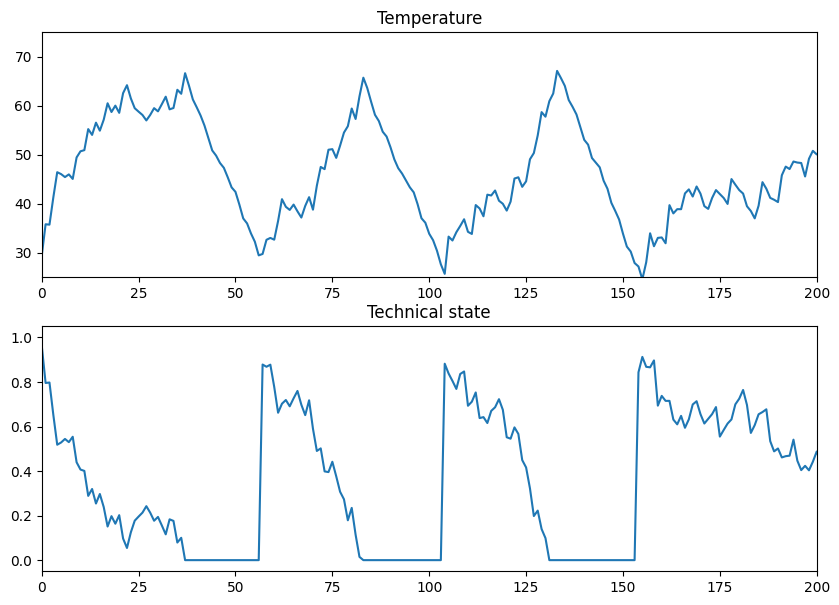

In [23]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(df['temp9'])
plt.xlim(0,200)
plt.ylim(25,75)
plt.title('Temperature')
plt.subplot(2,1,2)
plt.plot(df['state9'])
plt.xlim(0,200)
plt.title('Technical state')
plt.show()

## Корреляции технического состояния блоков с состоянием системы

Построим друг над другом графики состояния системы и состояния блоков, чтобы определить возможную взаимосвязь этих величин.

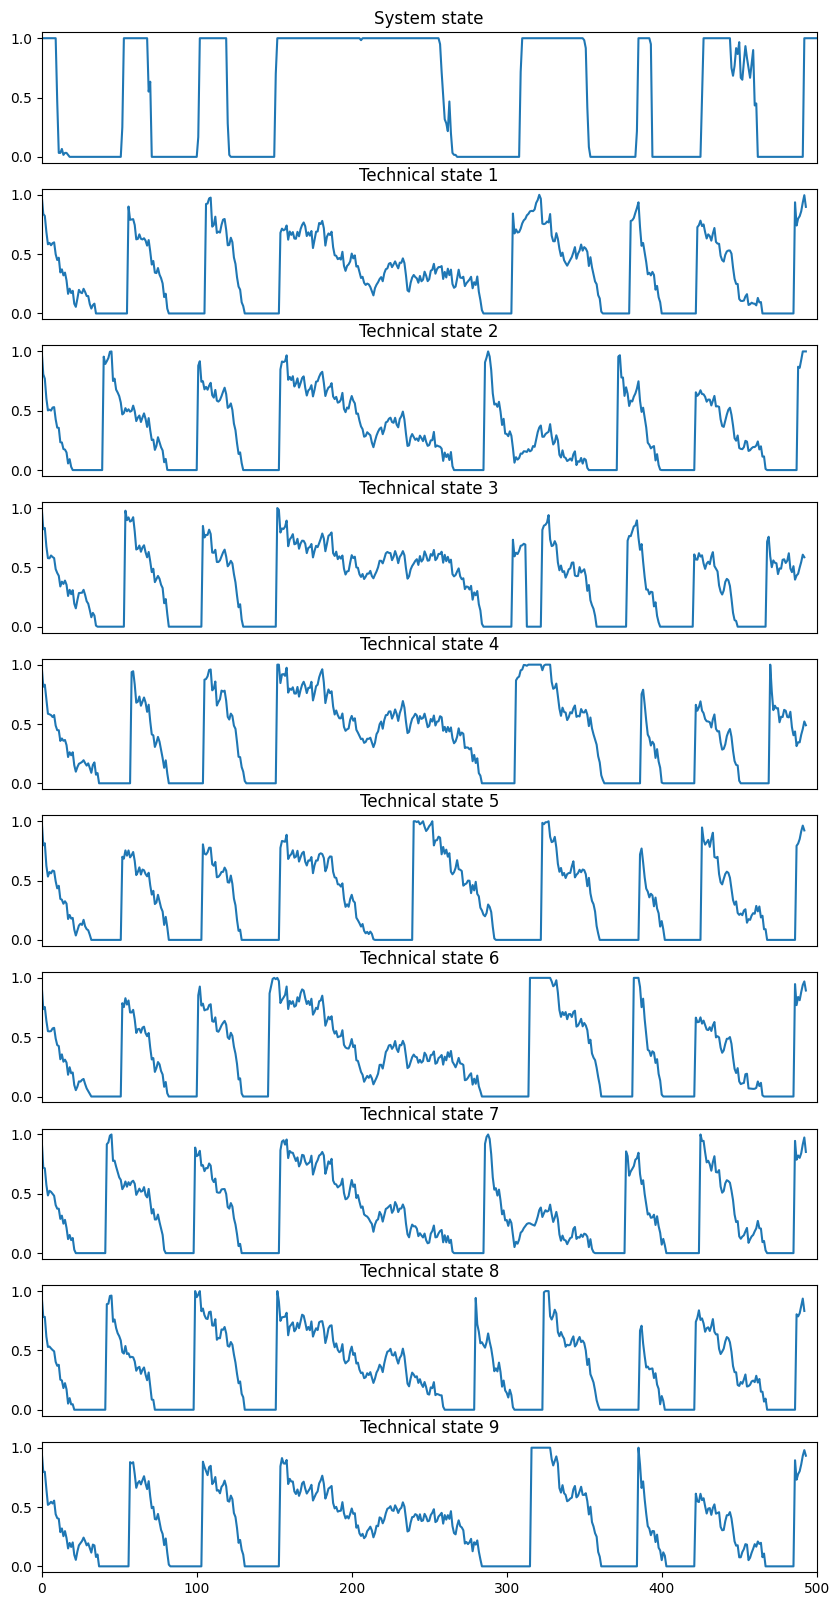

In [24]:
plt.figure(figsize=(10,20))
plt.subplot(10,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
for i in range(9):
    plt.subplot(10,1,i+2)
    plt.plot(df['state'+str(i+1)])
    plt.xlim(0,500)
    if i < 8:
        plt.xticks([])
    plt.title('Technical state '+str(i+1))
plt.show()

Наглядно видно, что состояние системы становится равным 0, когда какая-то часть блоков отключается и начинает охлаждаться. Поскольку блоки идентичные, то можно предположить, что каждый из них одинаковым образом влияет на состояния системы. Поэтому определим взаимосвязь состояния системы со средним значением состояния блоков.

#### **Задание 6**

Определите среднее состояние блоков с помощью метода **pd.DataFrame.agg()**.

In [25]:
sum_state = df[["state" + str(i+1) for i in range(9)]].agg("mean", axis="columns")

sum_state = sum_state[:x_lim]
len(sum_state)

500

Сравним на графиках состояние системы и среднее состояние блоков.

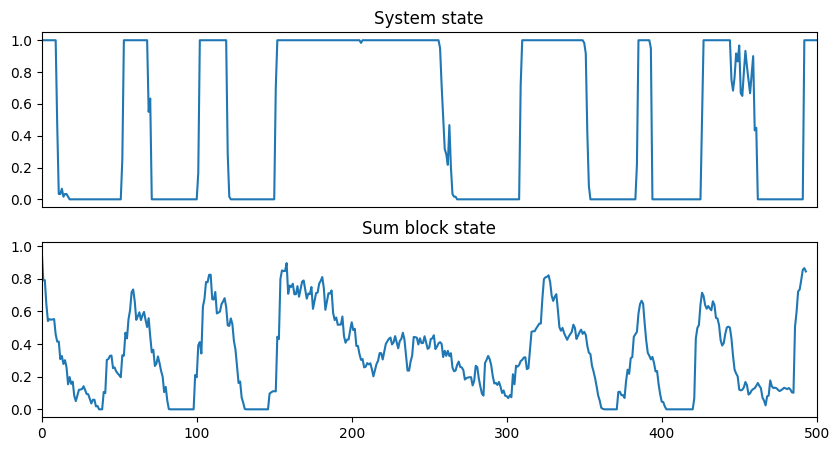

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(df['system_state'])
plt.xlim(0,500)
plt.xticks([])
plt.title('System state')
plt.subplot(2,1,2)
plt.plot(sum_state)
plt.xlim(0,500)
plt.title('Sum block state')
plt.show()

#### **Задание 7**

Для того, чтобы по состоянию блоков можно было определять состояние системы, нужно выбрать пороговое значение состояния блоков, выше которого состояние системы будет прогнозироваться равным 1, а ниже - равным 0. Сделаем это обычным перебором. Но для начала приведем значения состояния системы либо к значению 0, либо к значению 1.

Напишите функцию, которая будет рассчитывать точность соответствия состояния системы **system_state** и среднего состояния блоков **sum_state** для определенного порогового значения **threshold**. Точность - относительное число точных совпадений состояний блоков и системы (1 и 1 или 0 и 0).

In [27]:
system_state = np.ones(len(df))
system_state[df['system_state'] < 0.5] = 0.
system_state[:100]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
def accuracy(system_state, sum_state, threshold):

  sum_state_norm = np.ones(len(sum_state))
  sum_state_norm[sum_state < threshold] = 0.
  ans = 0
  for i in range(len(sum_state_norm)):
    ans += 1 if sum_state_norm[i] == system_state[i] else 0

  return ans / len(sum_state)

accuracy(system_state, sum_state, 0.5)

0.728

#### **Задание 8**

Определим точность для каждого значения порога в интервале от 0 до 1.

In [29]:
acc = []
thresholds = np.linspace(0., 1., num = 100)

for thres in thresholds:
  acc.append(accuracy(system_state, sum_state, thres))

Построим график зависимости точности от порога. На графике виден максимум, соответствующий оптимальному значению порога.

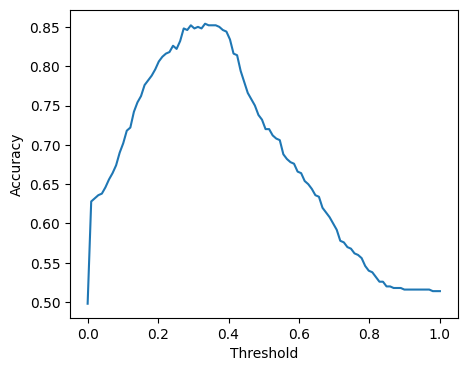

In [30]:
plt.figure(figsize=(5,4))
plt.plot(thresholds, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

#### **Задание 9**

Определите максимальное значение точности и оптимальное значение порога.

In [31]:
max_accuracy = np.max(acc)
optimal_threshold = acc.index(np.max(acc)) / 100

print('Maximum accuracy {:.3f} for the threshold {:.2f}'.format(max_accuracy, optimal_threshold))

Maximum accuracy 0.854 for the threshold 0.33


## Выводы

#### **Задание 10**

Напишите ниже выводы по результатам лабораторной работы.
Состояние системы описывается с лучшей точностью, при нормировании среднего состояния всех блоков с порогом 0.33